In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
# load the raw data in a pandas dataframe
df_raw = pd.read_csv("./drinking_water_potability.csv")
df_raw.columns
# df_raw = df_raw.drop(['Sulfate', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'], axis=1)



Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [3]:
# Check for missing data
df_raw.isna().sum()


ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

39.01 % of samples are potable (1)


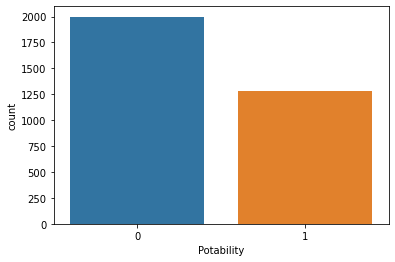

In [4]:
# view distribution
sns.countplot(x=df_raw["Potability"])

print(f'{df_raw.Potability[df_raw.Potability==1].count()/df_raw.Potability.count()*100:.2f} % of samples are potable (1)')

<AxesSubplot:>

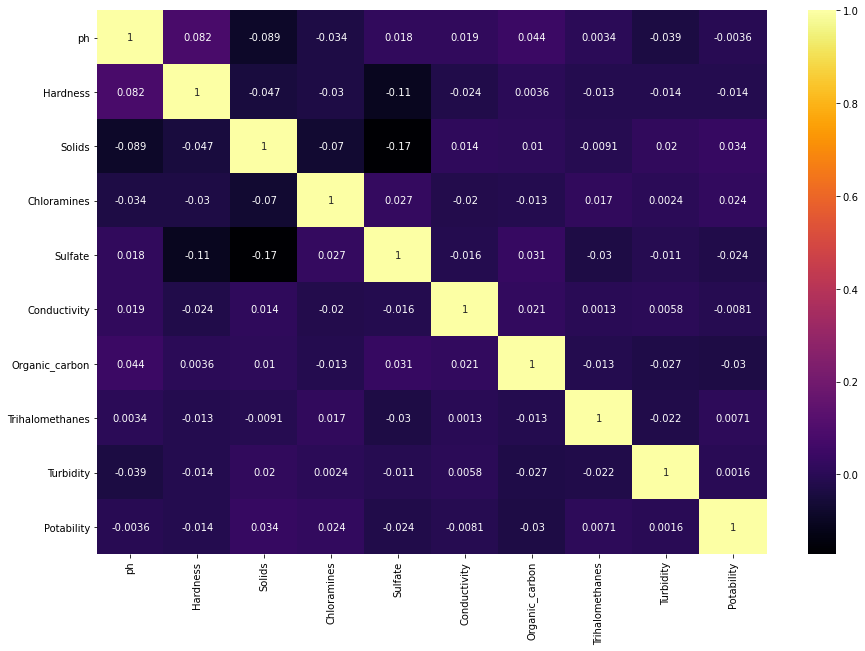

In [5]:
# Correlation matrix for dataset
plt.figure(figsize=(15,10))
sns.heatmap(df_raw.corr(), annot=True, cmap="inferno")

In [6]:
# Function to fill in missing data
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        # print(index, column)
        df[column] = df[column].fillna(df.groupby('Potability')[column].transform('mean'))
    return df
 

In [7]:
df = fill_nan(df_raw)

df.isna().sum() 

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [8]:
# Splitting
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=18, stratify=y) #stratify=y
# real_data = [
#     [6.8, 200, 513, .25, 1045],
#     [6.8, 250, 2, 0, 5],
#     [6.8, 150, 480, .1, 1015],
#     [6.8, 100, 540, 0, 1110],
#     [7.6, 250, 620, .25, 1220],
#     [6.8, 150, 540, 0, 1090],
#     [7.2, 200, 565, .4, 1130],
#     [7.6, 150, 620, .5, 1330]
# ]
# real_df = pd.DataFrame(real_data)
# X_new = X_test.append(real_data)
# Balancing data - oversampling minority
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)
print(X_test)
# Scaling
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)


            ph    Hardness        Solids  Chloramines     Sulfate  \
893   9.055826  196.475899  20226.287940     5.838594  298.803560   
3000  6.931244  207.588954  24359.470410     7.222004  313.819713   
2765  7.073783  161.250331  23469.220870     8.392832  332.566990   
2047  7.459124  195.028717  33173.499410     7.551374  332.566990   
996   6.836225  166.742962  24293.172660     6.861235  332.881582   
...        ...         ...           ...          ...         ...   
733   9.239440  212.569076  14829.624210     7.172920  324.128915   
3087  4.032061  200.067973  14720.544830     6.482679  334.564290   
907   5.296579  220.080832  39537.086460     9.232766  322.433592   
274   7.073783  156.520635  16146.157110     6.629599  352.353431   
1205  4.429379  256.212565   8746.901717     9.010332  332.566990   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  
893     342.359411       12.813634        84.279218   5.456913  
3000    477.062975       16.495092       

In [ ]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "Decision Tree": DecisionTreeClassifier(),
         "Naive Bayes": GaussianNB(),
         "ExtraTreesClassifier": ExtraTreesClassifier(),
         "xgb Classifier": XGBClassifier(),
         "CatBoostClassifier": CatBoostClassifier()}

In [ ]:
# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
   Fits and evaluates given machine learning models.
   models: a dict of different Scikit_Learn machine learning models
   X_train: training data (no labels)
   X_test: testing data (no labels)
   y_train: training labels
   y_test: test labels
   """ 
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                            scoring='accuracy',
                                            cv=5
                                            ).mean()

    return model_scores

In [ ]:
model_scores = fit_and_score(models,X_train,X_test,y_train,y_test)

model_scores

In [ ]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar(color="purple")

In [ ]:
#best performing model is xgb Classifyer, so thats what we will tune
from sklearn.model_selection import GridSearchCV
model = CatBoostClassifier()

# parameters = {'depth'           : [4,5,6,7,8,9,10],
#                  'learning_rate' : [0.03,0.04,.05,.06],
#                   'iterations'    : [50,60,70,80,90,100,120, 140]
#                  }

# Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train)
model.fit(X_train,y_train)
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)
y_pred = model.predict(X_new)
y_pred

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

In [ ]:
real_data = [
    [6.8, 200, 513, .25, 1045],
    [6.8, 250, 2, 0, 5],
    [6.8, 150, 480, .1, 1015],
    [6.8, 100, 540, 0, 1110],
    [7.6, 250, 620, .25, 1220],
    [6.8, 150, 540, 0, 1090],
    [7.2, 200, 565, .4, 1130],
    [7.6, 150, 620, .5, 1330]
]
real_df = pd.DataFrame(real_data)

real_df = sc.transform(real_df)
real_pred = Grid_CBC.predict(real_df)
real_pred

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances,n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    # Plot dataframe
    fix, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

In [ ]:
model = CatBoostClassifier()
model.fit(X_train, y_train)
plot_features(df.drop(['Potability'],axis=1).columns, model.feature_importances_)

In [ ]:
print(model)


In [ ]:
print(X_test[1])

# Neural Network

In [9]:
from torch import nn
from torch.nn import functional as F

In [18]:
#define a model for binary classification

class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64, 64)
    self.fc4 = nn.Linear(64,1)  

  def forward(self,x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = torch.relu(self.fc3(x))
      x = torch.sigmoid(self.fc4(x))
      return x

In [19]:
import torch



In [20]:
# X_train, X_test, y_train, y_test
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]  
    def __len__(self):
        return self.length

trainset = dataset(X_train,y_train)#DataLoader
# print(trainset.x)
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

# testset = dataset(X_test,y_test)#DataLoader

# testloader = DataLoader(testset,batch_size=64,shuffle=False)


In [21]:
#forward loop
losses = []
accur = []

#hyper parameters
learning_rate = 0.01
epochs = 1000
# Model , Optimizer, Loss
model = Net(input_shape=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) #Stochastic Gradient Descent, could be ADAM if we wanted
loss_fn = nn.BCELoss() #binary cross entropy

for i in range(epochs):
    for j,(X_train,y_train) in enumerate(trainloader):
        # print(X_train)
        #calculate output
        output = model(X_train)
    
        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))
    
        #accuracy
        predicted = model(torch.tensor(X_test,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y_test).mean()    
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%50 == 0:
        losses.append(loss.detach().numpy())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

epoch 0	loss : 0.7304668426513672	 accuracy : 0.3894993894993895
epoch 50	loss : 0.0007743860478512943	 accuracy : 0.5531135531135531
epoch 100	loss : 8.10556775832083e-06	 accuracy : 0.5482295482295483
epoch 150	loss : 2.134621809091186e-06	 accuracy : 0.5482295482295483
epoch 200	loss : 1.277787077924586e-06	 accuracy : 0.5482295482295483
epoch 250	loss : 8.968702900347125e-07	 accuracy : 0.5482295482295483
epoch 300	loss : 6.789382496208418e-07	 accuracy : 0.5494505494505495
epoch 350	loss : 5.38307119768433e-07	 accuracy : 0.5494505494505495
epoch 400	loss : 4.3958610262961884e-07	 accuracy : 0.5494505494505495
epoch 450	loss : 3.650797566479014e-07	 accuracy : 0.5494505494505495
epoch 500	loss : 3.1199402883430594e-07	 accuracy : 0.5494505494505495
epoch 550	loss : 2.691529630283185e-07	 accuracy : 0.5494505494505495
epoch 600	loss : 2.3655651659737487e-07	 accuracy : 0.5494505494505495
epoch 650	loss : 2.1141070760677394e-07	 accuracy : 0.5494505494505495
epoch 700	loss : 1.91852

In [ ]:
x = np.linspace(0,1000,1)
plt.plot(range(len(losses)), losses)
plt.plot(range(len(accur)), accur)
plt.legend(["Loss", "Accuracy"])
plt.show()